In [1]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import pandas as pd
import os
from treys import Card
from termcolor import colored
from utils import eval_listof_games , debug_listof_games, save_results , load_results

In [2]:
import skimage.io
import matplotlib.pyplot as plt
#libraries for exercise 1.2 Region growing
from skimage.segmentation import flood, flood_fill
from skimage import morphology
from skimage.morphology import closing, opening, disk, square
import numpy as np

#libraries for exercise 1.3 Contour detection
from skimage import filters
import scipy
import cv2 as cv

Import setup data

In [3]:
path_data = 'data/image_setup/'

backs = path_data + 'back_cards.jpg'
cards = path_data + 'spades_suits.jpg'
kings = path_data + 'kings.jpg'
chips = path_data + 'chips.jpg'

backs = skimage.io.imread(backs)
cards = skimage.io.imread(cards)
kings = skimage.io.imread(kings)
chips = skimage.io.imread(chips)

In [4]:
images = [backs, cards, kings, chips]

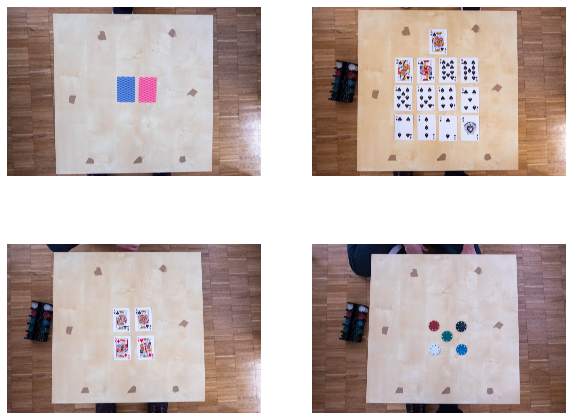

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))

for ax, image in zip(axes.flatten(), images):
    ax.imshow(image)
    ax.axis('off')
    ascii

## Cards treatment

In [6]:
print(cards.shape)

(4000, 6000, 3)


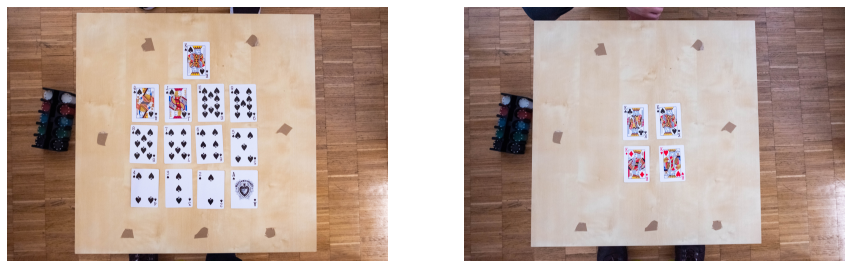

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(15,8))
for image,ax in zip([cards, kings], axes):
    ax.imshow(image)
    ax.axis('off')
plt.show()

### Isolate cards and symbols (ground truth)

In [8]:
# def plot_card(idx, idy, r, c):
#     fig, axes = plt.subplots(ncols=4, figsize=(10,8))
#     for ax,x,y in zip(axes.flatten(),idx, idy):
#         ax.imshow(cards[x:x+r,y:y+c])
#         ax.axis('off')
#     plt.show()

In [9]:
idx = [520,1190,1190,1190,1190,1840,1840,1840,1890,2530,2530,2550,2550]
row = 640
idy = [2750,1940,2460,2980,3480,1915,2450,2950,3500,1930,2470,2975,3500]
col = 470
individual_cards = []

for x,y in zip(idx, idy):
    card = cards[x:x+row, y:y+col]
    individual_cards.append(card)

In [10]:
idx = [50,50,50,45,50,35,50,50,40,40,45,45,49]
row = 70
idy = [40,40,35,35,40,50,40,35,40,50,40,40,40]
col = 50
numbers = []

for x,y,card in zip(idx, idy, individual_cards):
    number = card[x:x+row, y:y+col]
    numbers.append(number)

In [11]:
idx = [1600,1590,2265,2255]
row = 100
idy = [2575,3088,2592,3140]
col = 80
symbols = []

for x,y in zip(idx, idy):
    symbol = kings[x:x+row, y:y+col]
    symbols.append(symbol)

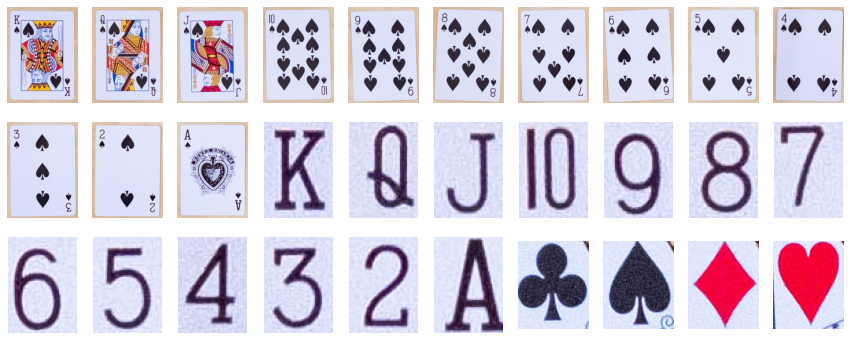

In [12]:
all_images = individual_cards + numbers + symbols
fig, axes = plt.subplots(ncols = 10, nrows = 3, figsize=(15,6))

for ax, image in zip(axes.flatten(),all_images):
    ax.imshow(image)
    ax.axis('off')
plt.show()

## Looking for feature detectable on train images
### Sobel filter + cleaning

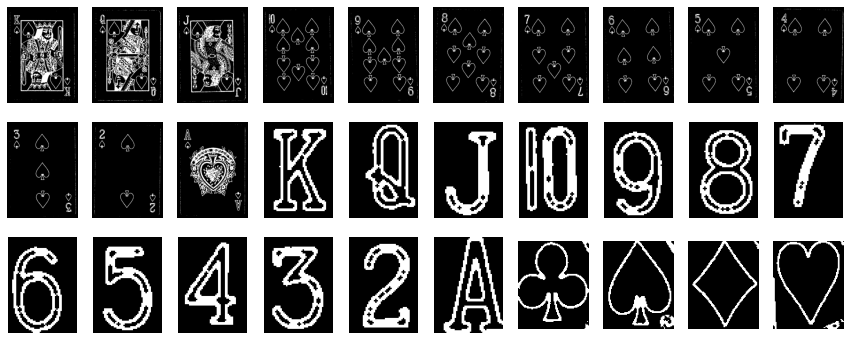

In [13]:
sobel_images = []

fig, axes = plt.subplots(ncols = 10, nrows = 3, figsize=(15,6))
for ax, image in zip(axes.flatten(), all_images):
    # sobel
    grayscale = skimage.color.rgb2gray(image)
    smoothed = filters.gaussian(grayscale, sigma = 20)
    sob = filters.sobel(grayscale)
    
    otsu = filters.threshold_otsu(sob)
    output = sob > otsu
    output = closing(output, disk(1))
    sobel_images.append(output)
    ax.imshow(output, cmap=plt.cm.gray)
    ax.axis('off')
plt.show()

### Contour detection on sobel output
#### biggest contour per image

In [14]:
def one_contour_by_img(img_list):
    """
    Extracts the biggest contour for each image
    return: list(contour_img_1, contour_img_2, ...)
    """
    cont_img = []
    
    #Contours of images
    for img in img_list:
        # Compute all contours in image
        contours, hierarchy = cv.findContours(img.astype(np.uint8) ,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

        # Case 1: 1 contour detected in image
        if len(contours) == 1:
            contour = contours[0][:,0]

        # Case 2: more than 1 contour detected
        else:
            # find and keep biggest contour, as others are artefacts
            big_contour_idx = 0
            for j in range(len(contours)):
                if len(contours[j]) > contours[big_contour_idx].shape[0]:
                    big_contour_idx = j
            contour = contours[big_contour_idx][:,0]

        # Record contour
        cont_img.append(contour)
    return cont_img

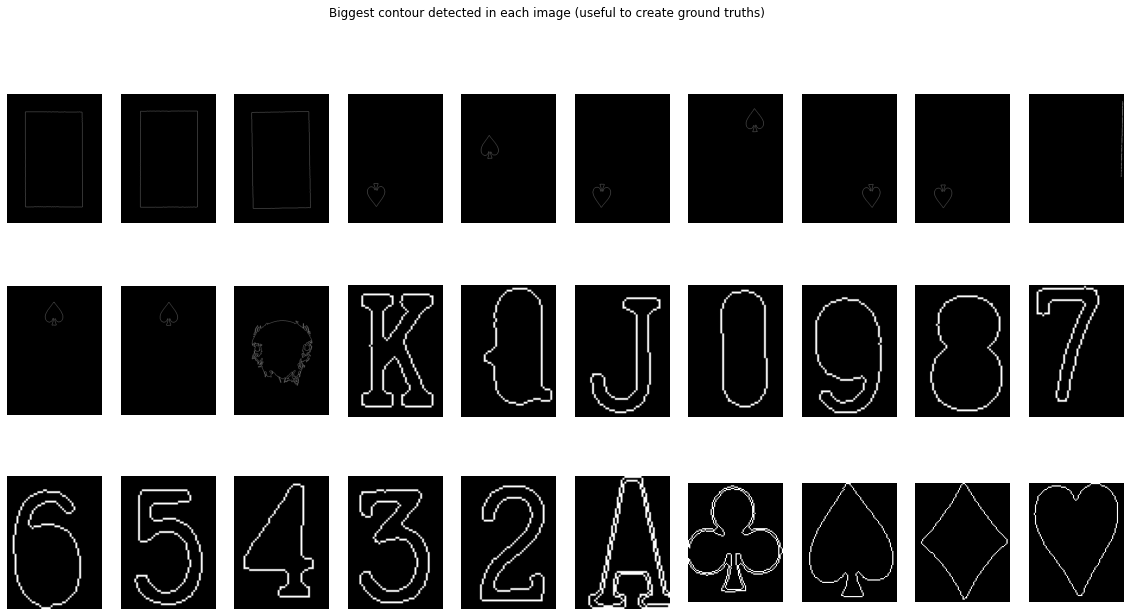

In [15]:
sobel_contours = one_contour_by_img(sobel_images)

fig, axes = plt.subplots(ncols = 10, nrows = 3, figsize=(20,10))
for ax, contour, image in zip(axes.flatten(), sobel_contours, all_images):
    im = np.zeros((image.shape[0], image.shape[1]))
    im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.axis('off')
fig.suptitle('Biggest contour detected in each image (useful to create ground truths)')
plt.show()

Note: when extracting full cards contours the biggest contour of "dressed" cards is the inner rectangle (can be used for cleaning before using contours ?) see cv2.fillPoly()

#### All contour in images

In [16]:
def contours_by_img(img_list):
    """ 
    Extracts all contours for each image
    return: list(  list(contour_1_img_1, ..., contour_m_img_1)  ,  ...,  list(contour_1_img_n, ..., contour_m_img_n)  )
    """
    cont_img = []
    
    #Contours of images
    for img in img_list:
        # Compute all contours in image
        contours, hierarchy = cv.findContours(img.astype(np.uint8) ,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        
        # Case 1: 1 contour detected in image
        if len(contours) == 1:
            contour = contours[0][:,0]
            contour = [contour]
            # append 1 contour in a list
            cont_img.append(contour)
            
            
        # Case 2: more than 1 contour detected
        else:
            # append all contours in a list (necessary reshaping)
            img_contours = [contours[i][:,0] for i in range(len(contours))]
            cont_img.append(img_contours)
        
    return cont_img

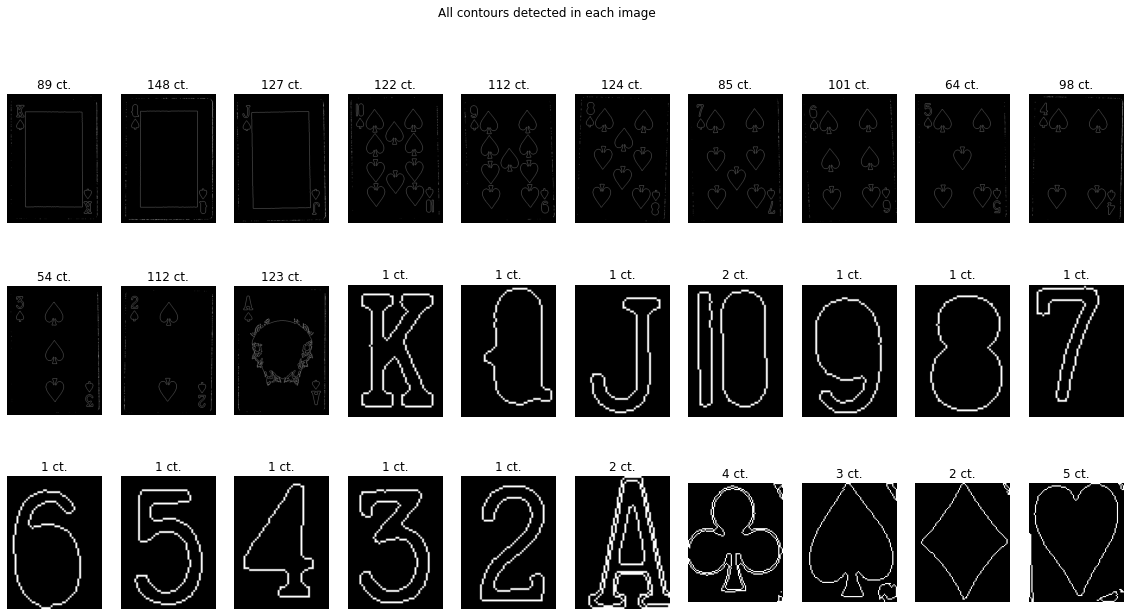

In [17]:
sobel_all_contours = contours_by_img(sobel_images)

fig, axes = plt.subplots(ncols = 10, nrows = 3, figsize=(20,10))
for ax, contours, image in zip(axes.flatten(), sobel_all_contours, all_images):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
fig.suptitle('All contours detected in each image')
plt.show()

### VERY IMPORTANT NOTE: inner contours of "dressed" cards are not detected, so no complex cleaning necessary ! We only find ourselves with the biggest and smallest contours (easy to clean out in theory) and symbols of interest.

#### Strategie from there: evaluate a range a contour length (tolerance because images not taken from same place each time) that we keep before making features

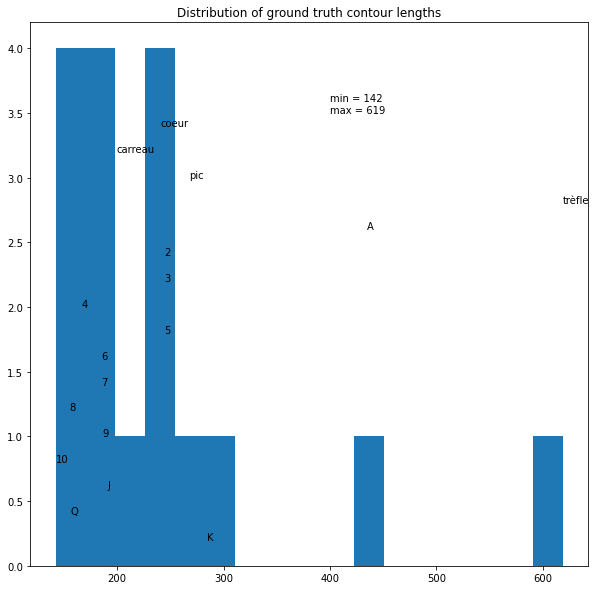

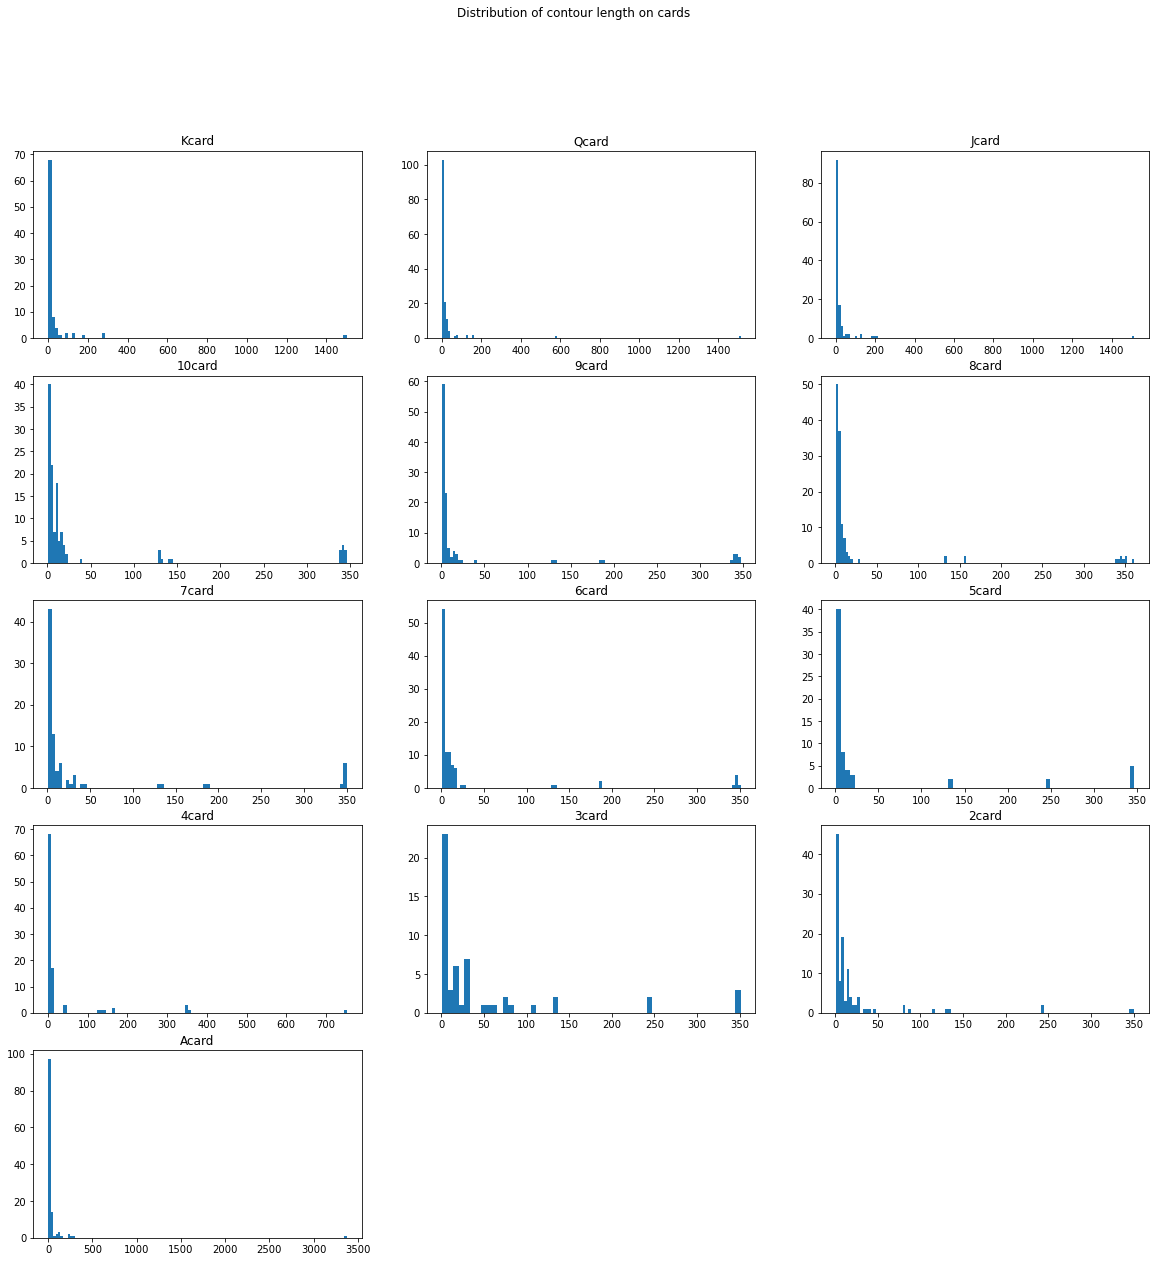

In [18]:
cards_contours = sobel_all_contours[:13] 
ground_truth_contours = [len(sobel_contours[i]) for i in range(13,30,1)]

card_titles = ['Kcard', 'Qcard', 'Jcard', '10card', '9card', '8card', '7card', '6card', '5card', '4card', '3card', '2card', 'Acard']
ground_truth_titles = ['K', 'Q', 'J', '10', '9', '8', '7', '6', '5', '4', '3', '2', 'A', 'trèfle', 'pic', 'carreau', 'coeur']

# plot ground truth distrib
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(ground_truth_contours, bins=len(ground_truth_contours))
plt.text(400,3.5, f'min = {np.min(ground_truth_contours)} \nmax = {np.max(ground_truth_contours)}')
for i, (x, card) in enumerate(zip(ground_truth_contours, ground_truth_titles)):
    plt.text(x, (i+1)*0.2, card)
plt.title('Distribution of ground truth contour lengths')
plt.show()


# plot cards distrib
fig, axes = plt.subplots(ncols = 3, nrows = 5, figsize=(20,20))
for ax, contours, title in zip(axes.flatten(), cards_contours, card_titles):
    lengths = [len(ct) for ct in contours]
    ax.hist(lengths, bins=len(lengths))
    ax.set_title(title)
axes[-1,-1].axis('off')
axes[-1,-2].axis('off')
fig.suptitle('Distribution of contour length on cards')
plt.show()

We notice a lot of very small contours, most likely the cards rectangle contours which are cut into very small pieces. Let's try to get rid of that.

In [19]:
tol = 80
cont_range = [142-tol, 619+tol]

down = cont_range[0]
up = cont_range[1]

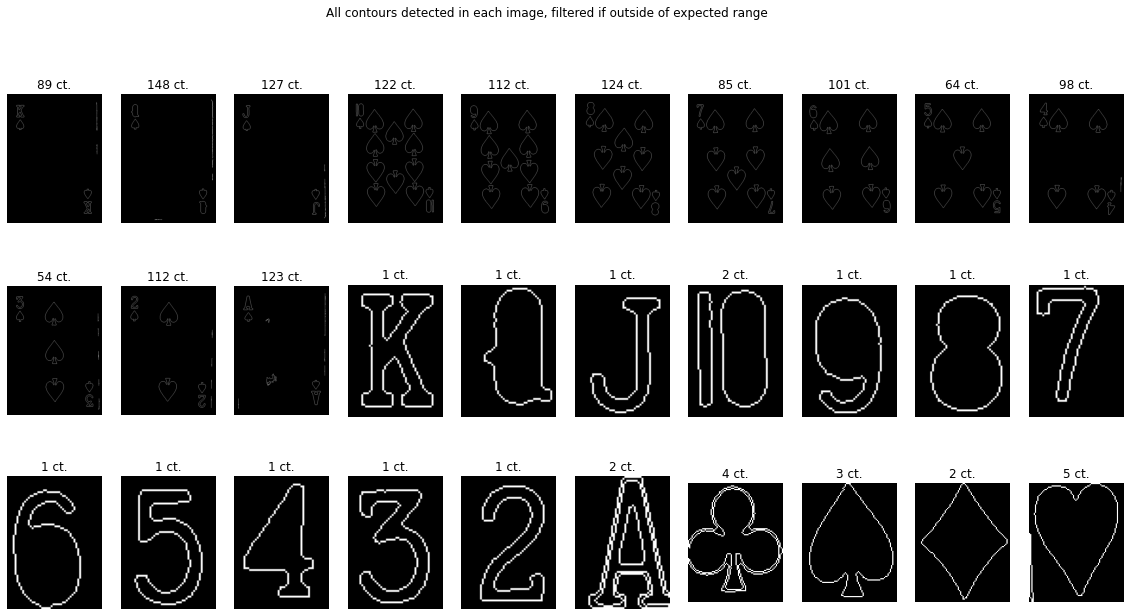

In [20]:
sobel_all_contours = contours_by_img(sobel_images)

fig, axes = plt.subplots(ncols = 10, nrows = 3, figsize=(20,10))
for ax, contours, image in zip(axes.flatten(), sobel_all_contours, all_images):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        size = len(contour)
        if size > down and size < up:
            im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im, cmap='gray')
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
fig.suptitle('All contours detected in each image, filtered if outside of expected range')
plt.show()

Note: we do not need to tolerance to be too restrictive.

MAYBE SIZE RANGE SELECTION IS NOT EVEN NECESSARY FOR CORRECT CLASSIFICATION, AND THEN THE PIPELINE WOULD GENERALIZED TO A MORE VARIABLE RANGE OF PICTURES.

Except from a few artefacts of the rectangle card contours or ace shapes, there only remains shapes of interest, which we can transform into features to create ground truth features. Then, use them to recognise cards.

## Features creation

Use **ground_truth_contours** to create features and see how **cards_contours** align to those features and classified